### YOLO_V3代码阅读，总结

#### 大纲

- 1.使用官方已训练yolo_v3检测物体

- 2.代码解读

- 3.训练自己的数据

- 4.引用

### 1.使用官方已训练的yolo_v3检测物体

- 1.1 准备工作：
    - 下载官方训练好的[权重](https://pjreddie.com/media/files/yolov3.weights) 此权重文件是weights文件
    - 将weights文件转化成h5权重文件， 执行一下命令 python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5
    - 下载检测的文件图片，放入image 文件夹中。
    - 执行命令 python yolo_video.py --image   执行后会让你输入图片的位置
    - 执行结果：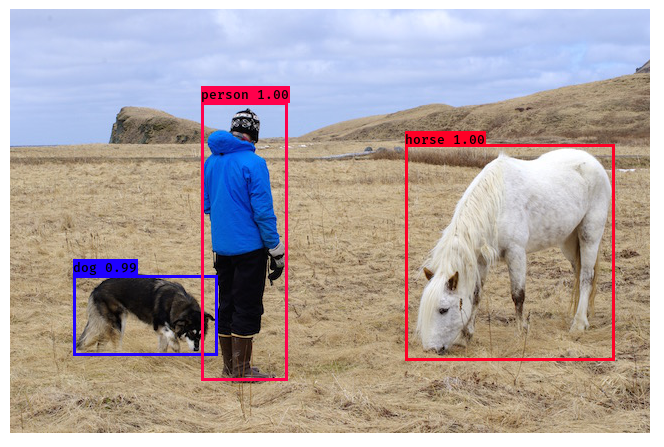

### 2. 代码解读

- 2.1首先推荐几个比较不错的博文
    - [这篇讲的非常系统，github地址有代码解读有文章链接](https://github.com/SpikeKing/keras-yolo3-detection)
    - [yolov3 Keras实现解读](https://danielack.github.io/2018/08/25/yolov3Keras%E5%AE%9E%E7%8E%B0%E8%A7%A3%E8%AF%BB/)
    
- 2.2在我看来yolo_v3代码，主要看懂三个模块(网上讲解代码很多，有些点，自己还是不明白。记录自己的理解)：
    - 训练数据构建真值
    - 模型结构，yolo_body
    - 损失函数
    
- 2.3训练数据构建真值（已coco数据为例，后面都是以coco数据进行的）

In [4]:
# 数据生成器 
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True) # 这里的边框数据  是左上点坐标和右下点坐标
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes) #真值 构造出 模型输出的结构
        yield [image_data, *y_true], np.zeros(batch_size)

数据生成器代码没什么好讲的，但是里面有两个方法需要关注，就是加注解的方法：get_random_data，preprocess_true_boxes，这两个方法的功能分别是：读取图片，构建标注框；构建真值，shape和模型输出的shape相同，接下来贴出这两块代码，重点讲解一下。

In [ ]:
# 1.解析数据 读取图片，解析边框
def get_random_data(annotation_line, input_shape, random=True, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True):
    '''random preprocessing for real-time data augmentation'''
    line = annotation_line.split()
    image = Image.open(line[0])
    iw, ih = image.size # 图片的大小
    h, w = input_shape # 输入大小
    box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

    if not random:
        # resize image
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2
        image_data=0
        if proc_img:
            image = image.resize((nw,nh), Image.BICUBIC)
            new_image = Image.new('RGB', (w,h), (128,128,128)) #将图片等比例转换为416x416的图片，其余用灰色填充，即(128, 128, 128)
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image)/255. #归一化数据

        # correct boxes
        box_data = np.zeros((max_boxes,5))
        if len(box)>0:
            np.random.shuffle(box)
            if len(box)>max_boxes: box = box[:max_boxes] # 最多20个
            box[:, [0,2]] = box[:, [0,2]]*scale + dx #边界框box等比例缩小，再加上填充的偏移量dx和dy
            box[:, [1,3]] = box[:, [1,3]]*scale + dy #边界框box等比例缩小，再加上填充的偏移量dx和dy
            box_data[:len(box)] = box

        return image_data, box_data
    return image_data, box_data

get_random_data 的主要功能是：读取图片，调整图片大小，归一化数据；调整边框（绝对位置，格式 （x_max,y_max,x_min,y_min,置信度,class））

In [ ]:
#构建真值
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format

    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5) # （批次 ， 20 ，5）
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer

    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value

    '''
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting  3
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # 作用是 分开anchor 给不同输出层使用

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    # 转化成中点 和边框宽高格式
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # (批次，20,2)
    # 归一化操作
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    m = true_boxes.shape[0] #批次数量
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] #[[13,13], [26,26], [52,52]] 最后输出框的大小
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)] #盛放真值 shape [[?,13,13,3,85], [?,26,26,3,85], [?,52,52,3,85]]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0) #(1,9,2)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0  # (批次，20)  boxes_wh[..., 0]  获取第一列  标记哪个有框  标记是否有边框

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]] # 有框的数据
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2. # 不明白为什么 除以2
        box_mins = -box_maxes

        ########################这段代码要反复看，没有理解其中含义################
        intersect_mins = np.maximum(box_mins, anchor_mins)  # np.maximum（） 具有传播性
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # 交叉处的面积
        box_area = wh[..., 0] * wh[..., 1] # 真实框的面积
        anchor_area = anchors[..., 0] * anchors[..., 1] #anchor的面积
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        #########################################################################

        # Find best anchor for each true box   根据iou找到没有框最适合的anchor（一个）
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true   #给出的边框是绝对位置，不是相对位置。

- 2.4 模型结构，yolo_body模块代码解读

![image.png](./yolo_v3_2.jpg)
![image.png](./yolo_v3_1.png)

第一张图是yolo_body模块的模块结构图，画的非常好，[原图作者](https://blog.csdn.net/leviopku/article/details/82660381).但是这个图没有显示每个模块的输出特征图shape。第二张图片显示了重要模块的输出shape

In [ ]:
# yolo网络
def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V3 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body(inputs)) #(?, 13, 13, 1024) #构造基础网络 darknet
    # 构造三个输出
    x, y1 = make_last_layers(darknet.output, 512, num_anchors*(num_classes+5)) # 现在的特征图为原来的 1/32

    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x) # 上采样后 特征图为原来的 1/16
    x = Concatenate()([x,darknet.layers[152].output]) # 拼接 backbone 处 1/16的特征图
    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x) #上采样 特征图为原来的 1/8 
    x = Concatenate()([x,darknet.layers[92].output]) # 拼接 backbone 处 1/8的特征图
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs, [y1,y2,y3]) # 输出为 y1: 13*13*225   y2:26*26*225   y3:52*52*225

yolo的网络主体非常简洁，darknet + fpn(特征金字塔网络)

- 2.5 损失函数

In [ ]:
def yolo_loss(args, anchors, num_classes, ignore_thresh=.5, print_loss=False):
    '''Return yolo_loss tensor

    Parameters
    ----------
    yolo_outputs: list of tensor, the output of yolo_body or tiny_yolo_body
    y_true: list of array, the output of preprocess_true_boxes
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    ignore_thresh: float, the iou threshold whether to ignore object confidence loss

    Returns
    -------
    loss: tensor, shape=(1,)

    '''
    num_layers = len(anchors)//3 # default setting
    yolo_outputs = args[:num_layers] # 模型的输出
    y_true = args[num_layers:] # 标签数据
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
    
    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0])) # 输入的shape
    grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)] # 模型数据的shape
    
    loss = 0
    m = K.shape(yolo_outputs[0])[0] # batch size, tensor 批次
    mf = K.cast(m, K.dtype(yolo_outputs[0]))

    #遍历每个尺度
    for l in range(num_layers):
        object_mask = y_true[l][..., 4:5] # 置信度，是否有对象
        true_class_probs = y_true[l][..., 5:]  # 分类的概率

        grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],
             anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True) # 构造 grid, 预测值，预测的xy,预测的wh
        #拼接xy wh 成框
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Darknet raw box to calculate loss.
        #将y_ture转换成最原始 的 没有加经过处理的输出 是yolo_head函数中转换xy wh的逆过程
        raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid
        #xy true一开始存储的是xy相对于整张图像的比例值大小 经过操作后 就变成 相对于相对于当前cell的偏移值了
        raw_true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        
        """
        大框给小权重，小框给大权重，因为大框的xywh不需要学得那么好，而小框则对xywh很敏感
        
        为了调整不同大小的预测框所占损失的比重，真值框越小，
        box_loss_scale越大，这样越小的框的损失占比越大，和v1，v2里采用sqrt(w)的目的一样
        """
        box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]

        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask
        _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        # K.binary_crossentropy is helpful to avoid exp overflow.
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
            (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
        class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

        xy_loss = K.sum(xy_loss) / mf
        wh_loss = K.sum(wh_loss) / mf
        confidence_loss = K.sum(confidence_loss) / mf
        class_loss = K.sum(class_loss) / mf
        loss += xy_loss + wh_loss + confidence_loss + class_loss
        if print_loss:
            loss = tf.Print(loss, [loss, xy_loss, wh_loss, confidence_loss, class_loss, K.sum(ignore_mask)], message='loss: ')
    return loss

In [ ]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    # 将模型特征图输出 转化成 框信息
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors) # anchor 的数量
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    # 构造网格
    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5]) 

    # Adjust preditions to each spatial grid point and anchor size.
    # #把特征图的输出转换成 相对于特征图的比例 和坐标相对于整张图像的比例是等价的  其实可以理解成   相对于输入
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
     #把宽高 wh转换成相对于整张图像的比例
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    #此时xy wh都是相对于图像大小的比例值
    return box_xy, box_wh, box_confidence, box_class_probs

### 3训练自己的数据
- 下载数据，使用[coco](http://cocodataset.org/) 
- coco的标注数据是json格式的，需要转化成（图片地址 以空格分割的多个框分类信息），使用yolo_v3 自带的工具（coco_annocation.py,改变里面的地址）
- coco_classes.txt 修改80个分类
- 修改 train.py classes_path对应的地址
- 执行 train.py 文件

#### 4 引用

- [keras-yolov3代码解读](https://blog.csdn.net/qq_25800609/article/details/87880651)  这边博文对 yolo_head,preprocess_true_boxes解释的很清楚
- [yolov3 Keras实现解读](https://danielack.github.io/2018/08/25/yolov3Keras%E5%AE%9E%E7%8E%B0%E8%A7%A3%E8%AF%BB/)
- [yolo系列之yolo v3【深度解析】](https://blog.csdn.net/leviopku/article/details/82660381)